## ewf-wfp-02-01-01 - Smoothed Gap-Filled Land Surface Temperature Time Series

Smoothed Gap-Filled Land Surface Temperature Time Series

---

### <a name="service">Service definition

In [25]:
# TO CHANGE
service = dict([('title', 'Smoothed Gap-Filled Land Surface Temperature Time Series'),
                ('abstract', 'Smoothed Gap-Filled Land Surface Temperature Time Series'),
                ('id', 'ewf-wfp-02-01-01')])

### <a name="parameter">Parameter Definition 

In [26]:
#start_year = dict([('id', 'start_year'),
#                ('value', 2015),
#                ('title', 'start year'),
#                ('abstract', 'start year')])
#
#end_year = dict([('id', 'end_year'),
#                ('value', 2015),
#                ('title', 'end year'),
#                ('abstract', 'end year')])

### <a name="runtime">Runtime parameter definition

**Input identifiers**

This is the MDOIS stack of products' identifiers

In [27]:
# 2015
input_identifiers = ('MOD11C2.A2015001.006.2016223171153', 'MOD11C2.A2015009.006.2016223171154', 'MOD11C2.A2015017.006.2016223171154', 'MOD11C2.A2015025.006.2016223171154', 'MOD11C2.A2015033.006.2016223171154')

# 2016
#input_identifiers = ('MOD11C2.A2016001.006.2016234032340', 'MOD11C2.A2016009.006.2016234032341', 'MOD11C2.A2016017.006.2016234032342', 'MOD11C2.A2016025.006.2016234032341', 'MOD11C2.A2016033.006.2016235185021')

# 2017
#input_identifiers = ( 'MOD11C2.A2017001.006.2017013160908', 'MOD11C2.A2017009.006.2017020191355', 'MOD11C2.A2017017.006.2017025093208', 'MOD11C2.A2017025.006.2017033125003', 'MOD11C2.A2017033.006.2017041092627')

## 2018
#input_identifiers = ( 'MOD11C2.A2018001.006.2018011143504', 'MOD11C2.A2018009.006.2018017084533', 'MOD11C2.A2018017.006.2018025152434', 'MOD11C2.A2018025.006.2018033090239', 'MOD11C2.A2018033.006.2018041083108')

#input_identifiers

**Input references**

This is the MODIS stack catalogue references

In [28]:
#input_references = ('https://catalog.terradue.com/modis/search?uid=MOD11C2.A2017001.006.2017013160908', 'https://catalog.terradue.com/modis/search?uid=MOD11C2.A2017009.006.2017020191355', 'https://catalog.terradue.com/modis/search?uid=MOD11C2.A2017017.006.2017025093208') 

#input_references = tuple(['https://catalog.terradue.com/modis/search?uid={0}'.format(pid) for pid in input_identifiers])

input_references = tuple(['https://catalog.terradue.com/modis/search?format=atom&uid={0}'.format(pid) for pid in input_identifiers])

**Data path**

This path defines where the data is staged-in. 

In [29]:
data_path = '/workspace/data/modis'

**Aux folders**

In [30]:
output_folder = ''

In [31]:
temp_folder = 'temp'

#### Import Modules

In [32]:
import os
import shutil
import datetime
import sys

#from datetime import datetime, timedelta

try:
    import gdal
except ImportError:
    from osgeo import gdal
import glob

import h5py

# whittaker engine

#sys.path.append('/application/notebook/libexec/')
#sys.path.append(os.getcwd())

#import modape
#from modape.modis import ModisRawH5, ModisSmoothH5, ModisMosaic

sys.path.append(os.getcwd())
sys.path.append('/application/notebook/libexec/')
from modis import ModisRawH5, ModisSmoothH5, ModisMosaic

#### Auxiliary methods

In [33]:
# remove contents of a given folder
# used to clean a temporary folder
def rm_cfolder(folder):
    #folder = '/path/to/folder'
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)


#e.g. '2016-01-01'
def get_formatted_date(date_str):
    date = datetime.datetime.strftime(date_str, '%Y-%m-%dT00:00:00Z')
    return date


def write_properties_file(output_name, first_date, last_date, region_of_interest):
    
    title = 'Output %s' % output_name
    
    first_date = get_formatted_date(first_date)
    last_date = get_formatted_date(last_date)
    
    with open(output_name + '.properties', 'wb') as file:
        file.write('title=%s\n' % title)
        file.write('date=%s/%s\n' % (first_date, last_date))
        file.write('geometry=%s' % (region_of_interest))

In [34]:
#Create folders
#if not os.path.isdir(data_path):
#    os.mkdir(data_path)

if len(output_folder) > 0:
    if not os.path.isdir(output_folder):
        os.mkdir(output_folder)

if not os.path.isdir(temp_folder):
    os.mkdir(temp_folder)

#### Collect raw MODIS data into HDF5 file

In [35]:

#modis_abs_paths = [data_path + '/' + in_id + '.hdf' for in_id in input_identifiers]

modis_abs_paths = [os.path.join(data_path, in_id + '.hdf' ) for in_id in input_identifiers]


try:
    rh5 = ModisRawH5(modis_abs_paths,
                     vam_product_code='LTD',
                     targetdir=temp_folder,
                     interleave=False)
    if not rh5.exists:
        rh5.create(compression='gzip',
                   chunk=None)
    rh5.update()
    
except Exception as e: # pylint: disable=unused-variable
    #print('\nError processing product {}, product code {}. \n\n Traceback:\n'.format(rh5.product, vam_product_code))
    print('something went wrong!!')
    pass


#modis_abs_paths

In [32]:
# checks file name
os.listdir(temp_folder + '/LTD')

['MOD11C2.006.TDT.h5']

#### Smooth raw MODIS HDF5 file

In [33]:

h5file = os.path.join(temp_folder, 'LTD', os.listdir(temp_folder + '/LTD')[0] )

#h5 = '/workspace/data/modis/rawh5/LTD/MOD11C2.006.TDT.h5'

#if not os.path.isfile(h5):
#    print('Raw HDF5 {} not found! Please check path.'.format(h5))
    

#smt_h5 = ModisSmoothH5(rawfile=h5,
#                       startdate=args.startdate,
#                       tempint=args.tempint,
#                       nsmooth=args.nsmooth,
#                       nupdate=args.nupdate,
#                       targetdir=args.targetdir,
#                       nworkers=args.nworkers)

smt_h5 = ModisSmoothH5(rawfile=h5file,
                       #startdate='2017001', # Startdate for temporal interpolation (format YYYY-MM-DD or YYYYJJJ)
                       tempint=10,
                       targetdir=temp_folder,
                       nworkers=2)

if not smt_h5.exists:
    smt_h5.create()

smt_h5.ws2d_sgrid()

#### Convert HDF5 to TIFF

In [34]:

h5_filepath = glob.glob(temp_folder + '/' + '*.TDT.h5')[0]
    


with h5py.File(h5_filepath, 'r') as h5f:
    dset = h5f.get('data')
    dates = h5f.get('dates')
    dim = dset.shape
    startdate = dates[0].decode()
    enddate = dates[-1].decode()
    temporalresolution = dset.attrs['temporalresolution']
    resolution = dset.attrs['resolution']
    nodata_value = dset.attrs['nodata']
    processing_timestamp = dset.attrs['processingtimestamp']
    ncols = dset.attrs['RasterXSize'].item()
    nrows = dset.attrs['RasterYSize'].item()



h5files_select_vpc = [h5_filepath]

mosaic = ModisMosaic(files=h5files_select_vpc,
                     datemin=datetime.date(2000, 1, 1).strftime('%Y%m'),
                     datemax=datetime.date.today().strftime('%Y%m'),
                     global_flag=True)
dset = 'data'


filenames = []
file_dates = []
for ix in mosaic.temp_index:
    
    datetime_object =  datetime.datetime.strptime(str(int(startdate) + 10*ix), '%Y%j')
    
    
    #filename = output_folder + '/' + 'modis_lst_10d_' + str(datetime_object.date()) + '.tif'
    
    filename = os.path.join(output_folder, 'modis_lst_10d_' + str(datetime_object.date()) + '.tif' )
    
    filenames.append(filename)
    file_dates.append(datetime_object.date())
    
    #filename = '/workspace/modis/lol' + '/' + 'modis_lst_10d_' + str(datetime_object.date()) + '.tif'
    
    print('Processing file {}'.format(filename))
    
    with mosaic.get_raster(dset, ix) as mosaic_ropen:
        #try:
        wopt = gdal.WarpOptions(dstSRS='EPSG:4326',
                                    outputType=mosaic_ropen.dt_gdal[0],
                                    xRes=mosaic_ropen.resolution_degrees,
                                    yRes=mosaic_ropen.resolution_degrees,
                                    srcNodata=mosaic.nodata,
                                    dstNodata=mosaic.nodata,
                                    resampleAlg='near',
                                    multithread=True,
                                    creationOptions=['COMPRESS=LZW', 'PREDICTOR=2'],)

        _ = gdal.Warp(filename,
                          mosaic_ropen.raster,
                          options=wopt)

        _ = None
        #except Exception as e:
        #    print('erro')
            #print('Error while reading {} data for {}! Please check if dataset exits within file. \n\n Error message:\n\n {}'.format(args.dataset, filename, e))
    
    del mosaic_ropen
    
    

    

filenames


Processing file modis_lst_10d_2015-01-05.tif
Processing file modis_lst_10d_2015-01-15.tif
Processing file modis_lst_10d_2015-01-25.tif
Processing file modis_lst_10d_2015-02-04.tif


['modis_lst_10d_2015-01-05.tif',
 'modis_lst_10d_2015-01-15.tif',
 'modis_lst_10d_2015-01-25.tif',
 'modis_lst_10d_2015-02-04.tif']

#### write properties files

In [35]:

for output_name,file_date in zip(filenames,file_dates):
    
    print(file_date)
    
    # all world
    region_of_interest = 'POLYGON((-179.9999 89.9999, 179.9999 89.9999, 179.9999 -89.9999, -179.9999 -89.9999, -179.9999 89.9999))'
    
    write_properties_file(output_name, file_date, file_date, region_of_interest)

2015-01-05
2015-01-15
2015-01-25
2015-02-04


#### Remove temporay files and folders

In [36]:
rm_cfolder(temp_folder)

os.rmdir(temp_folder)

#### Check a tif file

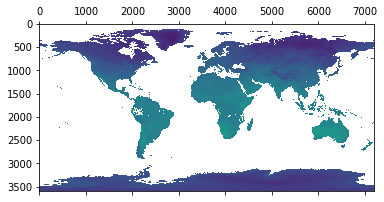

In [20]:
'''
import georasters

# Load data
#raster = output_folder + '/regtdt201602d1.tif'
raster = 'modis_lst_10d_2015-01-05.tif'
data = georasters.from_file(raster)

# Plot data
data.plot()
'''